# MC Generation and pulse fitting
---

In [ ]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from matplotlib import rc

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

In [ ]:
#ns
t_min = 0
t_max = 200

tau_scint = 40
n_events_scint = 10000

tau_sipm  = 10
n_events_DCR = 1000


In [ ]:
#scintillation signal
def f_scint(x, xmin, xmax):
    integral = -tau_scint*np.exp(-xmax/tau_scint) + tau_scint*np.exp(-xmin/tau_scint)
    return np.exp(-x/tau_scint)/integral

In [ ]:
#SiPM response
def f_DCR(x, xmin, xmax):
    return np.full(x.size, 1./(xmax-xmin))

In [ ]:
def makeRandomEvents(xmin, xmax, ymin, ymax, howMany):
        xArray=(xmin + np.random.random(howMany)*(xmax-xmin))
        yArray=(ymin + np.random.random(howMany)*(ymax-ymin))
        return [xArray, yArray]

def plotRandomNumbers(Numbers):
    plt.plot(Numbers[0],Numbers[1], 'ro')

In [ ]:
def plotFunction(f, minx, maxx, numpoints=100, scaleFactor=1):
    #make the x-values:
    stepsize = float(maxx-minx)/numpoints
    x = np.arange(minx, maxx, stepsize)
    plt.plot(x, f(x, minx, maxx)*scaleFactor)

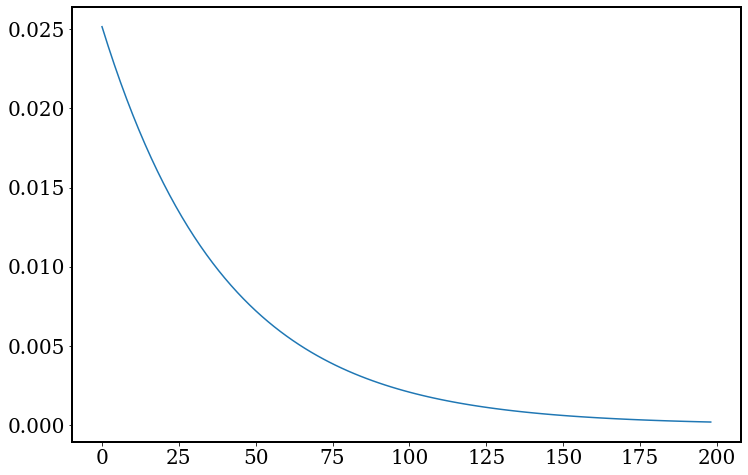

In [ ]:
plotFunction(f_scint, 0, 200)

In [ ]:
def MCIntegration(f, xmin, xmax, ymax, howMany, plotopt="withPlot"):
        Numbers=makeRandomEvents(xmin, xmax, 0, ymax, howMany)

        counter=0
        for x, y in zip(Numbers[0], Numbers[1]):
            if y < f(x, xmin, xmax):
                counter = counter + 1

        fractionInside = float(counter)/len(Numbers[0])
        boxsize        = (xmax-xmin)*ymax
        integralValue  = fractionInside * boxsize

        uncertainty    = math.sqrt(howMany*fractionInside*(1-fractionInside))/howMany * boxsize  #standard deviation of binomial
        if plotopt == "withPlot":
            plotRandomNumbers(Numbers)
            plotFunction(f, xmin, xmax)
            plt.show()
            print("integral value = ", integralValue, " +- ", uncertainty)

        return integralValue, uncertainty

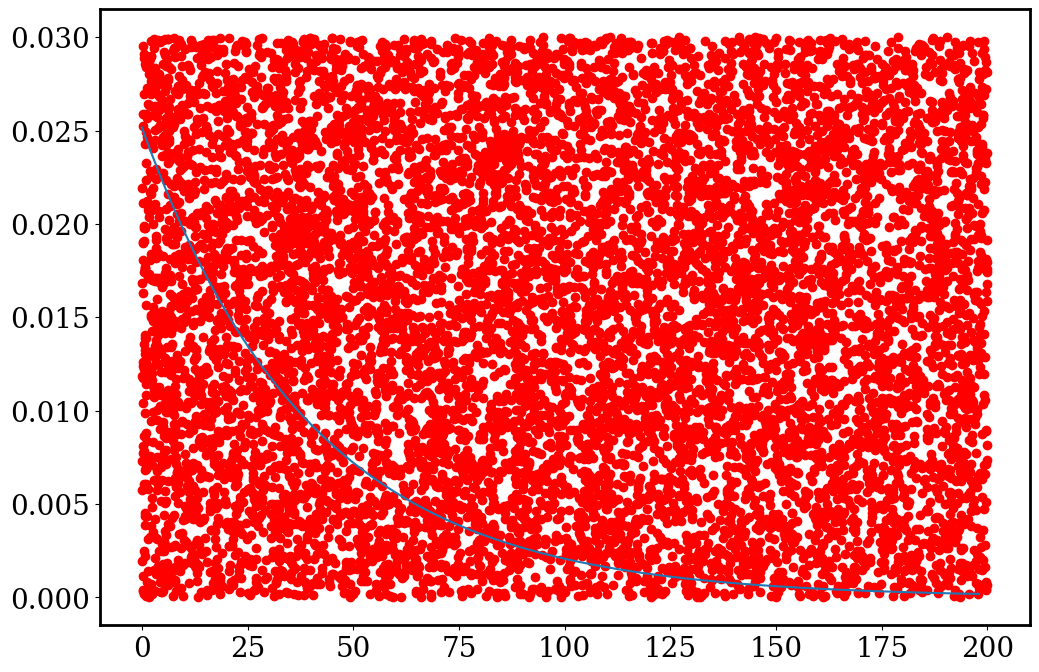

integral value =  0.9971999999999999  +-  0.02233560422285459


In [ ]:
result = MCIntegration(f_scint, 0, 200, 0.03, 10000)

In [ ]:
def MCGeneration(f, xmin, xmax, ymax, howMany, plotopt="withPlot"):
        Numbers=makeRandomEvents(xmin, xmax, 0, ymax, howMany)

        outputArray=[]
        counter=0
        for x, y in zip(Numbers[0], Numbers[1]):
            if y < f(x, xmin, xmax):
                outputArray.append(x)

        if(plotopt == "withPlot"):
            nbins=100
            if howMany/nbins < 10:
                nbins = int(howMany/10)

            binwidth=(xmax-xmin)/nbins
            plotFunction(f, xmin, xmax, scaleFactor=binwidth*len(outputArray))
            plt.hist(outputArray, nbins, range=(xmin,xmax))
            plt.show()
        return outputArray

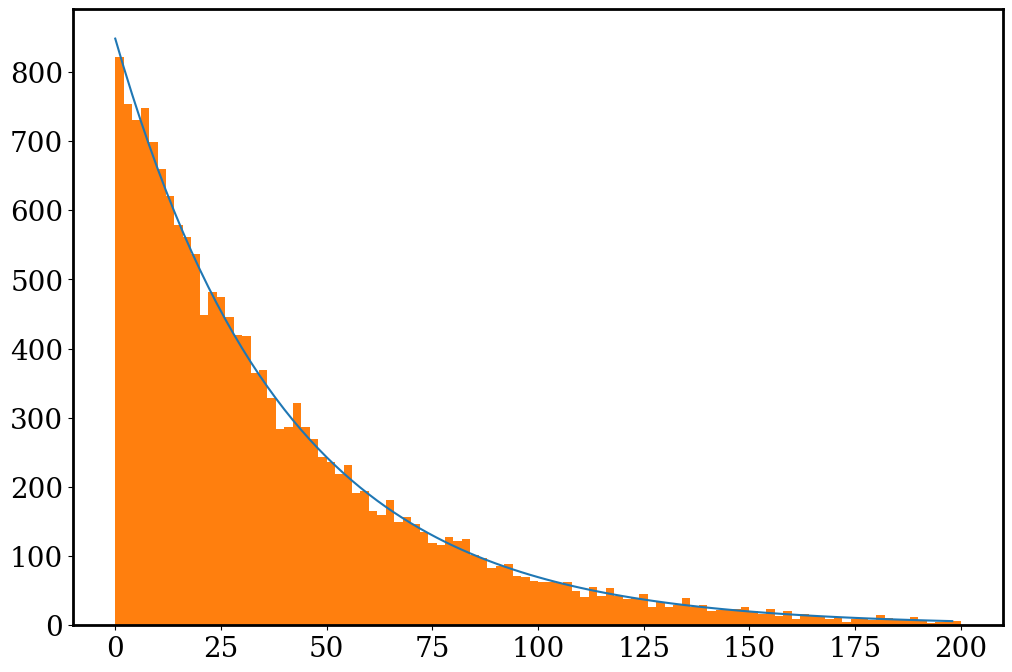

In [ ]:
GeneratedEvents = MCGeneration(f_scint, 0, 200, 0.03, 100000)

In [ ]:
#SiPM response
def f_sipm(x, t_shift=0):
    return np.exp(-(x-t_shift)/tau_sipm) * (x>t_shift)  #pure exponential, not normalized

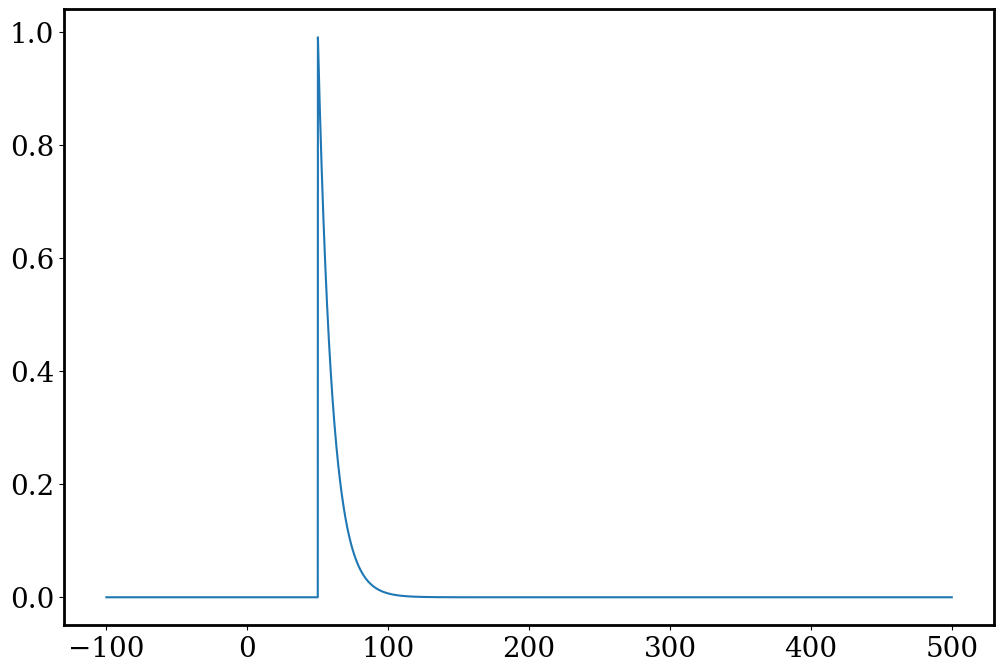

In [ ]:
x = np.arange(-100, 500, 0.1)
y = f_sipm(x, t_shift = 50)

plt.plot(x, y)

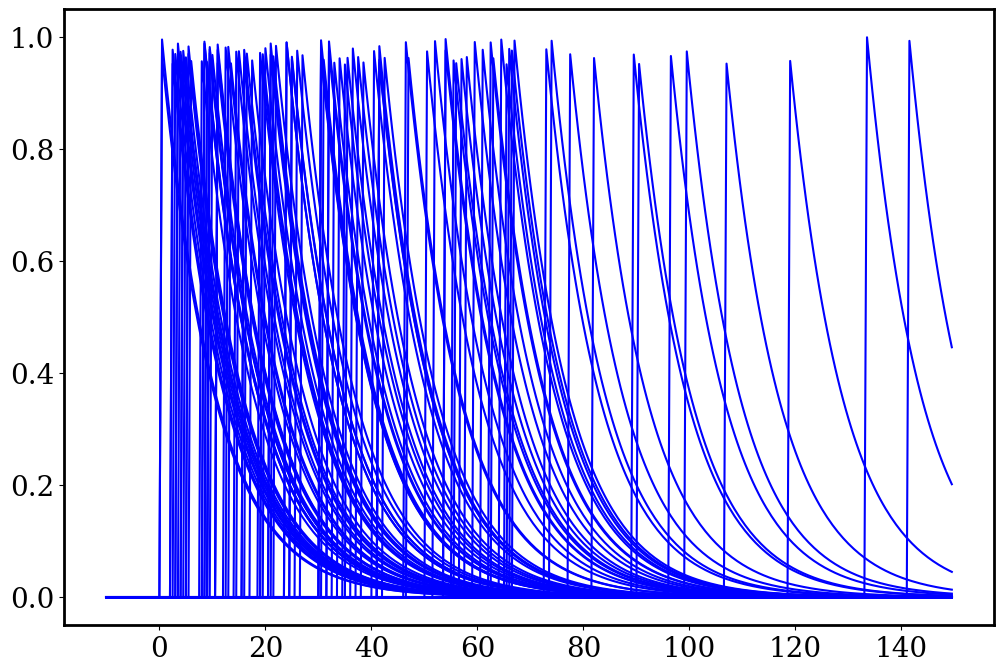

In [ ]:
range_min = -10
range_max = 150
step = 0.5

x_globalEvent = np.arange(range_min, range_max, step)
y_globalEvent = np.zeros(x_globalEvent.size)

for itr,evt in enumerate(GeneratedEvents):
    yy = f_sipm(x_globalEvent, t_shift=evt)
    y_globalEvent += yy

    if itr<100:
        plt.plot(x_globalEvent, yy, color="blue")


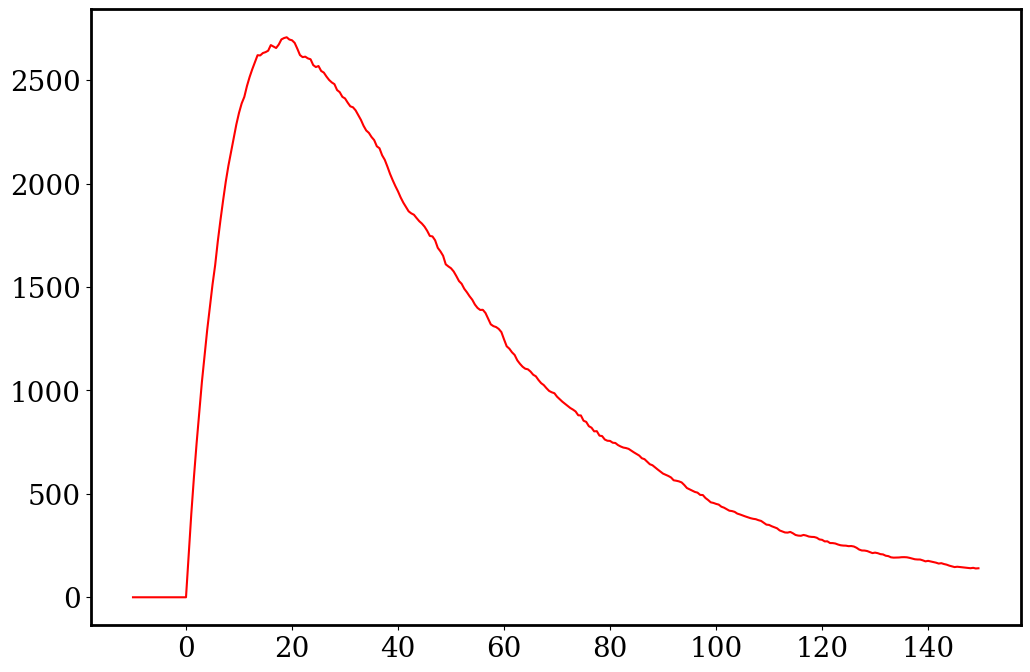

In [ ]:
plt.plot(x_globalEvent, y_globalEvent, "red")

In [ ]:
t_shift = 0
xmin = -300
xmax = 500

def norm_exp(x, tau):
    return np.exp(-(x-t_shift)/tau) * (x > t_shift)

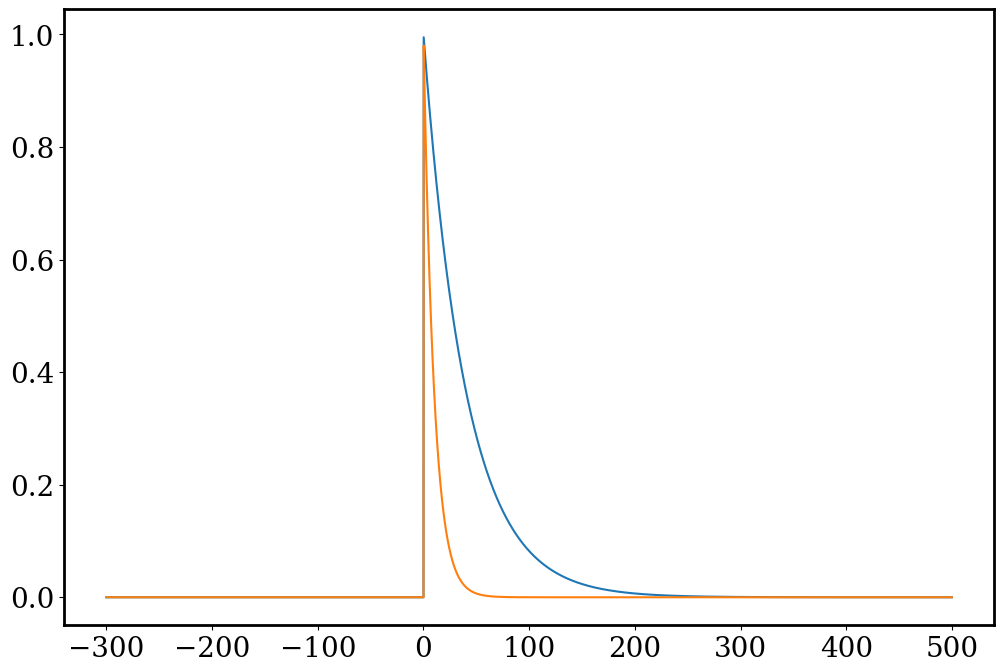

In [ ]:
x1 = np.arange(xmin, xmax, 0.2)
y1 = norm_exp(x1, 40)

x2 = np.arange(xmin, xmax, 0.2)
y2 = norm_exp(x2, 10)

plt.plot(x1, y1)
plt.plot(x2, y2)

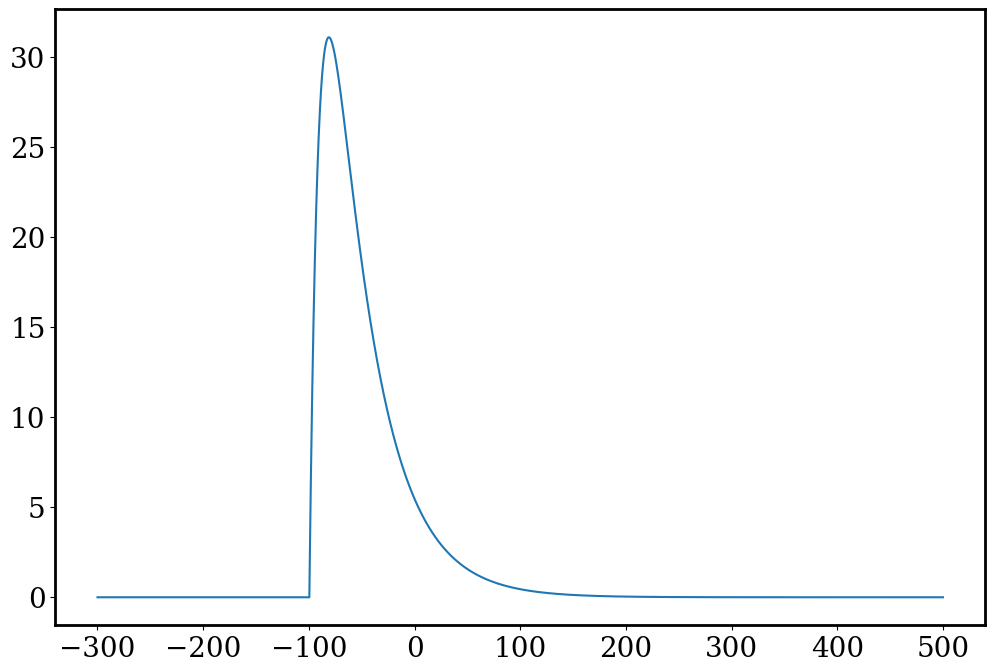

In [ ]:
#numerical convolution of two exponentials
yConv = np.convolve(y1, y2, "same")
plt.plot(x1, yConv)

Elasped time:  1.7396399974822998


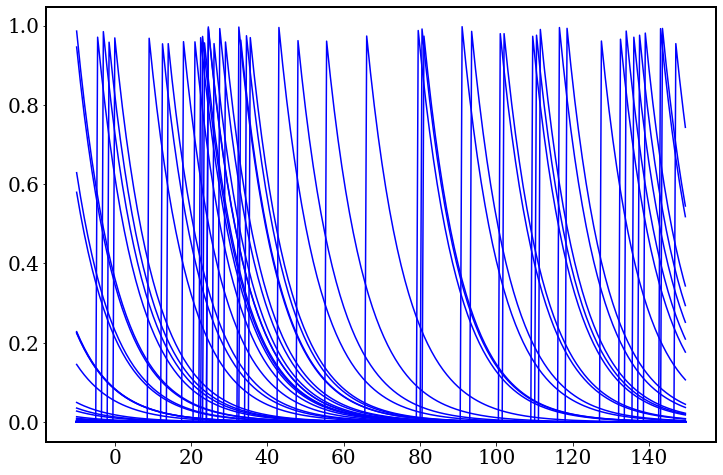

In [ ]:
#how the DCR noise looks like

start = time.time()

nDCR = 100000
xmin = -100
xmax = 200

GeneratedEventsDCR = (xmin + np.random.random(nDCR)*(xmax-xmin)) #flat probability to occur

x_globalEvent_sb = np.copy(x_globalEvent)
y_globalEvent_sb = np.copy(y_globalEvent)

for itr,evt in enumerate(GeneratedEventsDCR):
    x = np.arange(range_min, range_max, step)
    y = f_sipm(x, t_shift=evt)

    y_globalEvent_sb += y

    if itr<100:
        plt.plot(x, y, color="blue")

print("Elasped time: ", time.time()-start)

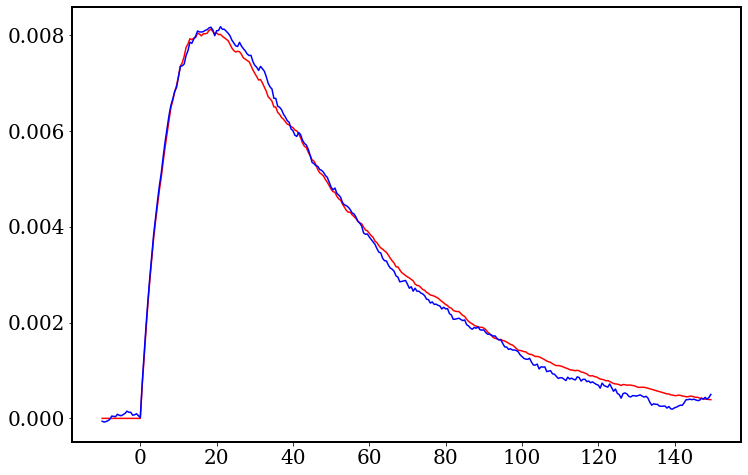

In [ ]:
plt.plot(x_globalEvent, y_globalEvent/np.sum(y_globalEvent), "red")
plt.plot(x_globalEvent_sb, (y_globalEvent_sb - np.mean(y_globalEvent_sb[0:10]))/np.sum(y_globalEvent), "blue") #subtract baseline and normalize to the same area



## Fitting the pulses

- define the fitting function and fit the pulse shape
- confirm that the fitted parameters reflect what was used in the generation

see discussion at https://iopscience.iop.org/article/10.1088/0031-9155/61/7/2802/pdf


In [ ]:
def fitFunc(t, tauRise, tauDecay, theta, norm):
    return norm * (np.exp(-(t-theta)/tauDecay) - np.exp(-(t-theta)/tauRise))/(tauDecay - tauRise) * (t > theta) #heaviside

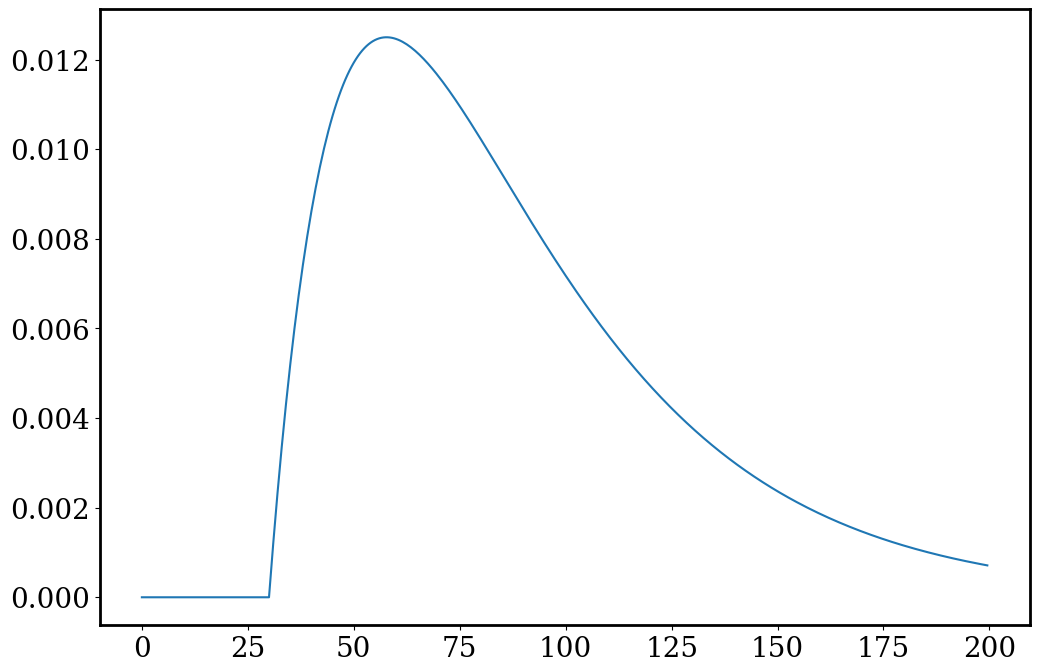

In [ ]:
xtest = np.arange(0, 200, 0.5)
ytest = fitFunc(xtest, 20, 40, 30, 1)

plt.plot(xtest, ytest)

In [ ]:
initial_guess = np.array([10, 40, 0, 0.5])
bounds = np.array([[0,0,-100, 0],[20,80,100, 100]])

popt,pcov = curve_fit(fitFunc, xdata=x_globalEvent, ydata=y_globalEvent/np.sum(y_globalEvent),
         p0=initial_guess,
         sigma=None, #else None
         bounds=bounds,#(-np.inf,np.inf)
         )

perr = (np.diag(pcov))**0.5
for i in range(len(popt)):
    print('Parametro ', i+1, ': ', popt[i], ' +/- ', perr[i])

Parametro  1 :  10.135661476503454  +/-  0.04779084351623544
Parametro  2 :  39.401502502065696  +/-  0.0957843286820012
Parametro  3 :  0.05904046688808053  +/-  0.017777725488428934
Parametro  4 :  0.5153670649926915  +/-  0.0004511168191234279


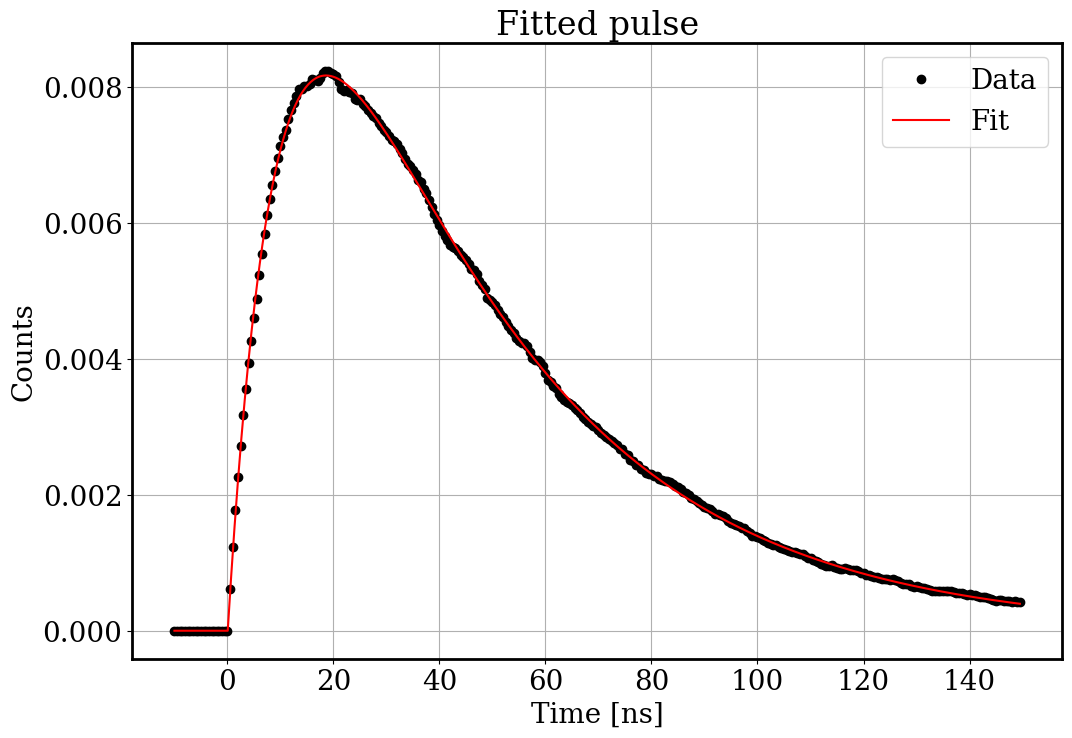

In [ ]:
x_fit = np.linspace(np.min(x_globalEvent),np.max(x_globalEvent),1000)

plt.plot(x_globalEvent,y_globalEvent/np.sum(y_globalEvent),'o',color='k',label='Data')
plt.plot(x_fit,fitFunc(x_fit,*popt),color='r',label='Fit')

#plt.plot(x,fit_func(x,*popt),color='r',label='Fit')

plt.grid(True, which="both",alpha=1)
plt.xlabel('Time [ns]')
plt.ylabel('Counts')
plt.title('Fitted pulse')
plt.legend(loc='best')

plt.show()